# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score, \
                                    GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from category_encoders import WOEEncoder, SumEncoder, OrdinalEncoder

from scipy.stats import mannwhitneyu, ttest_ind

In [2]:
X_train = pd.read_csv('data/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('data/y_train.csv', header=None, index_col=0)[1]
X_holdout = pd.read_csv('data/X_holdout.csv', index_col='Unnamed: 0')
y_holdout = pd.read_csv('data/y_holdout.csv', header=None, index_col=0)[1]
X_target = pd.read_csv('data/X_target.csv', index_col='Unnamed: 0')

In [3]:
X_train.shape

(32000, 207)

In [4]:
model = GradientBoostingClassifier()
skf = StratifiedKFold(n_splits=3, shuffle=True)

train_sizes_abs, train_scores, test_scores = learning_curve(model,
                                                            X_train,
                                                            y_train,
                                                            cv=skf,
                                                            scoring='roc_auc',
                                                            n_jobs=-1,
                                                            verbose=10)

[learning_curve] Training set sizes: [ 2133  6933 11733 16533 21333]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   15.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   23.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   34.3s remaining:   51.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   49.9s remaining:   43.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   59.5s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.1min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished


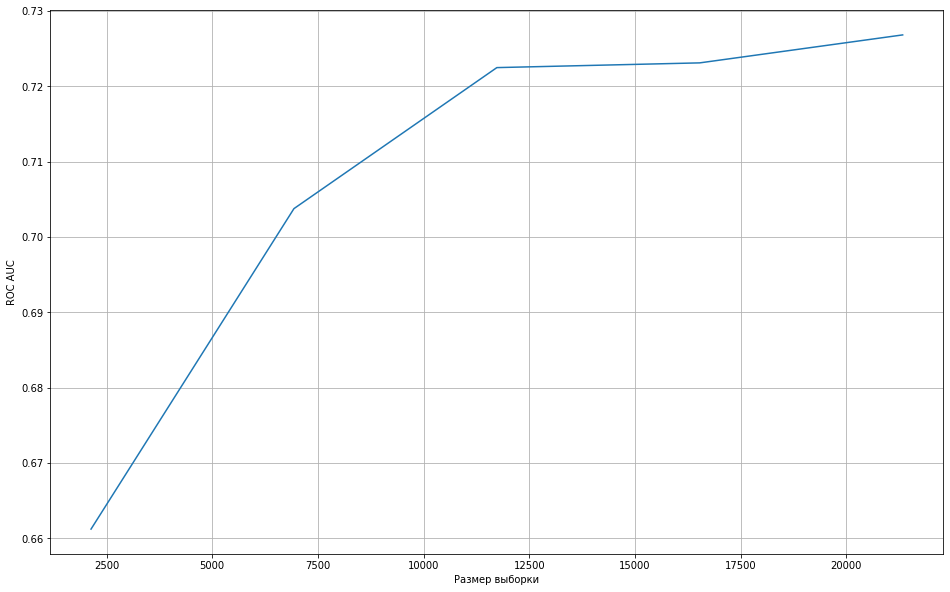

In [5]:
plt.figure(figsize=(16, 10))
plt.plot(train_sizes_abs, test_scores.mean(axis=1))
plt.ylabel('ROC AUC')
plt.xlabel('Размер выборки')
plt.grid()

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [6]:
weights = np.linspace(2, 20, 10, dtype='int')

roc_aucs = []
for weight in [y_train.map({-1: 1, 1: i}) for i in weights]:
    model.fit(X_train, y_train, sample_weight=weight)
    roc_auc = roc_auc_score(y_holdout, model.predict(X_holdout))
    roc_aucs.append(roc_auc)

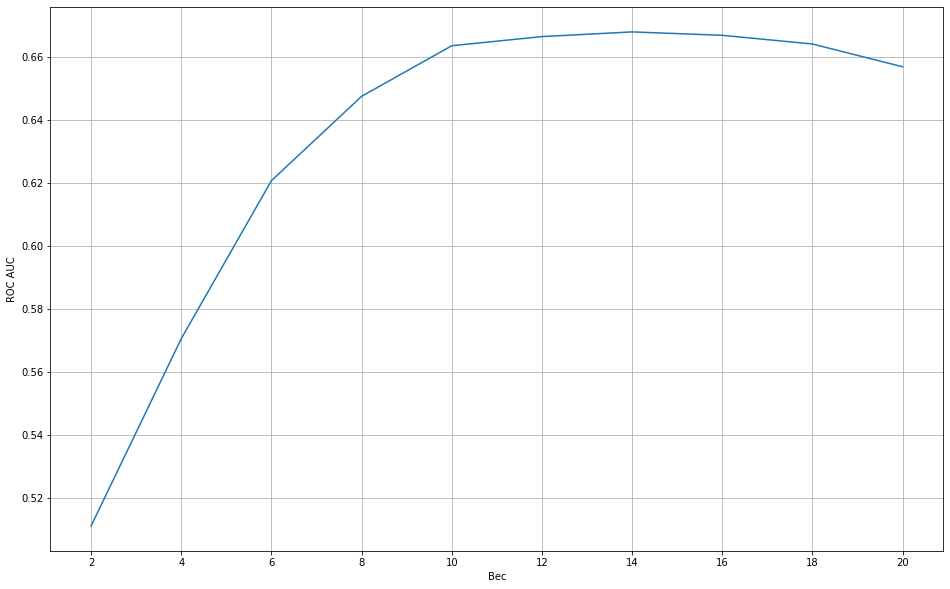

In [7]:
plt.figure(figsize=(16, 10))
plt.plot(weights, roc_aucs)
plt.ylabel('ROC AUC')
plt.xlabel('Вес')
plt.xticks(weights, weights)
plt.grid()
plt.show()

In [8]:
print('The best ROC AUC:', np.max(roc_aucs))
print('The best weight:', weights[np.argmax(roc_aucs)])

The best ROC AUC: 0.6678340208466912
The best weight: 14


Попробую посчитать оптимальный вес.

In [9]:
counted_weight = y_train.map({-1: 1, 1: 0}).mean() / y_train.map({-1: 0, 1: 1}).mean()
y_train_counted_weight = y_train.map({-1: 1, 1: counted_weight})
model.fit(X_train, y_train, sample_weight=y_train_counted_weight)
roc_auc = roc_auc_score(y_holdout, model.predict(X_holdout))
print('Optimal 1-class weight', counted_weight)
print('Optimal ROC AUC', roc_auc)

Optimal 1-class weight 12.439731205375894
Optimal ROC AUC 0.6682669556681551


In [10]:
y_train_weights = y_train.map({-1: 1, 1: counted_weight})

Лучший ROC AUC получается при весе 1-го класса 12.44.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [11]:
fracs = np.round(np.linspace(1, 0.05, 20), 2)
roc_aucs = []
for frac in fracs:
    X_train_frac = pd.concat([X_train[y_train == -1].sample(frac=frac), X_train[y_train == 1]])
    y_train_frac = y_train[X_train_frac.index]
    model.fit(X_train_frac, y_train_frac)
    roc_auc = roc_auc_score(y_holdout, model.predict(X_holdout))
    roc_aucs.append(roc_auc)

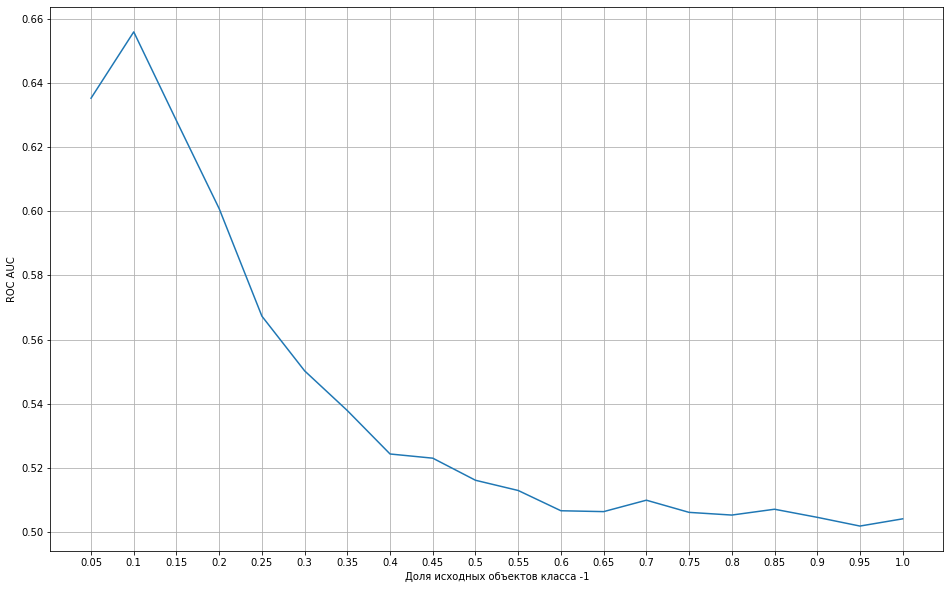

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(fracs, roc_aucs)
plt.ylabel('ROC AUC')
plt.xlabel('Доля исходных объектов класса -1')
plt.xticks(fracs, fracs)
plt.grid()
plt.show()

In [13]:
print('The best ROC AUC:', np.max(roc_aucs))
print('The best frac:', fracs[np.argmax(roc_aucs)])

The best ROC AUC: 0.6559297317846787
The best frac: 0.1


Посчитаю и проверю оптимальную долю.

In [14]:
frac_plus = y_train.map({-1: 0, 1: 1}).mean()
frac_minus = y_train.map({-1: 1, 1: 0}).mean()
optimal_frac = frac_plus / frac_minus

X_train_optimal_frac = pd.concat([X_train[y_train == -1].sample(frac=optimal_frac), X_train[y_train == 1]])
y_train_optimal_frac = y_train[X_train_optimal_frac.index]
model.fit(X_train_optimal_frac, y_train_optimal_frac)
roc_auc = roc_auc_score(y_holdout, model.predict(X_holdout))

print('Optimal fraction', optimal_frac)
print('Optimal ROC AUC', roc_auc)

Optimal fraction 0.0803875890475708
Optimal ROC AUC 0.6737004862714837


3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

1. Загрузка исходных данных.
1. Выбор столбцов, с которыми буду работать — удаление пустых столбцов.
1. Разбиение тестовой выборки на train и holdout.
1. Построение Pipeline:
    1. Обработка пропусков вещественных признаков.
    1. Обработка пропусков категориальных признаков.

In [15]:
X = pd.read_csv('data/orange_small_churn_data.train.txt')
y = pd.read_csv('data/orange_small_churn_labels.train.txt', header=None)[0]
X_target = pd.read_csv('data/orange_small_churn_test_data.csv', index_col='ID')

In [16]:
nan_features = []
universal_features = []

for feature in X.columns:
    unique_values = X[feature].value_counts().shape[0]
    if unique_values == 0:
        nan_features.append(feature)
    elif unique_values == 1:
        universal_features.append(feature)

drop_features = nan_features + universal_features

num_features = [feat for feat in ['Var' + str(num) for num in np.linspace(1, 190, 190, dtype='int')]
                        if feat not in drop_features]
cat_features = [feat for feat in ['Var' + str(num) for num in np.linspace(191, 230, 40, dtype='int')]
                        if feat not in drop_features]

In [17]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [18]:
num_transformer = Pipeline([('imputer', SimpleImputer(fill_value=0))])
cat_transformer = Pipeline([('imputer', SimpleImputer(fill_value='NaN')),
                            ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features)])
gboost_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier())])

param_grid = {'preprocessor__num__imputer__strategy': ['mean', 'median', 'constant'],
              'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant']}

gboost_grid = GridSearchCV(gboost_pipeline,
                           param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=skf,
                           verbose=10)
weights = y_train.map({-1: 1, 1: counted_weight})
gboost_grid.fit(X_train, y_train, estimator__sample_weight=weights)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 11.7min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 12.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 14.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                               

In [19]:
print('Лучший ROC AUC:', gboost_grid.best_score_)
print(gboost_grid.best_params_)

Лучший ROC AUC: 0.735936237782249
{'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__imputer__strategy': 'mean'}


Лучшие стратегии обработки пропусков:
1. Вещественные признаки: замена средним.
1. Категориальные признаки: замена отдельным значением (NaN).

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
cat_handlers = [OrdinalEncoder(),
                OneHotEncoder(handle_unknown='ignore')]

cross_val_results = []
for cat_handler in cat_handlers:
    num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
    cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='no', verbose=10)),
                                ('encoder', cat_handler)])

    preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                      ('cat', cat_transformer, cat_features)])
    gboost_pipeline = Pipeline([('preprocessor', preprocessor),
                                ('estimator', GradientBoostingClassifier())])
    cross_val_results.append(cross_val_score(gboost_pipeline,
                                             X_train,
                                             y_train,
                                             scoring='roc_auc',
                                             cv=skf,
                                             fit_params={'estimator__sample_weight': weights},
                                             n_jobs=-1,
                                             verbose=20))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


In [21]:
print('OrdinalEncoder ROC AUC: {}\nOneHotEncoder ROC AUC: {}'.format(*map(np.mean, cross_val_results)))

OrdinalEncoder ROC AUC: 0.7263383379047493
OneHotEncoder ROC AUC: 0.7327967512593668


5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [22]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                            ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
                            ('encoder', OrdinalEncoder())])
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features)])
lasso_pipeline = Pipeline([('preprocessor', preprocessor),
                           ('estimator', Lasso())])

sels = []
for alpha in np.logspace(-3, -1, 3):
    sel = SelectFromModel(Lasso(alpha=alpha))
    sel.fit(preprocessor.fit_transform(X_train, y_train), y_train)
    sels.append(sel)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.15777228525076, tolerance: 0.881535487499992
  positive)


In [23]:
significant_colums = X_train.drop(drop_features, axis='columns').columns[sels[0].get_support()]

num_filtered_features = [num for num in num_features if num in significant_colums]
cat_filtered_features = [cat for cat in cat_features if cat in significant_colums]

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='no', verbose=10)),
                            ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_filtered_features),
                                  ('cat', cat_transformer, cat_filtered_features)])
gboost_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier())])
score = cross_val_score(gboost_pipeline,
                                         X_train,
                                         y_train,
                                         scoring='roc_auc',
                                         cv=skf,
                                         fit_params={'estimator__sample_weight': weights},
                                         n_jobs=-1,
                                         verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.7s finished


In [24]:
score.mean()

0.733586880140184

Отбор признаков позволил немного увеличить roc auc.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [25]:
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='no')),
                            ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_filtered_features),
                                  ('cat', cat_transformer, cat_filtered_features)])
gboost_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier())])

param_grid = {'estimator__learning_rate': [0.05, 0.1, 0.2],
              'estimator__n_estimators': [50, 75, 100],
              'estimator__max_depth': [3, 4, 5],
              'estimator__max_features': ['auto', None],
              'estimator__subsample': [0.5, 0.75, 1]}

grid = GridSearchCV(gboost_pipeline,
                    param_grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=skf,
                    verbose=20)
grid.fit(X_train, y_train, estimator__sample_weight=weights)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed: 25.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 43.3min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed: 44.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 60.4min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 60.7min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 61.3min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 61.4min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed: 61.8min
[Paralle

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                               

In [26]:
grid.best_score_, grid.best_params_

(0.735421226403936,
 {'estimator__learning_rate': 0.05,
  'estimator__max_depth': 4,
  'estimator__max_features': 'auto',
  'estimator__n_estimators': 100,
  'estimator__subsample': 0.75})

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Не вижу смысла исследовать важность признаков из-за использования OneHotEncoder. В моем случае модель работает с другим признаковым пространством.
В случае регрессии можно делать выводы о важности признаков по соответствующим весам модели.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

Проведу t-тест для проверки гипотезы о равенстве различных вещественных признаков в двух группах: опредленных правильно и не правильно.

In [60]:
X_holdout_fillna = X_holdout[num_features].fillna(X_holdout[num_features].mean())
ttest_results = np.array([ttest_ind(X_holdout_fillna[right][feature],
                                    X_holdout_fillna[wrong][feature])[1] for feature in num_features])

In [67]:
significant_vars = np.array(num_features)[ttest_results < 0.05]
for var, right_mean, wrong_mean in zip(significant_vars,
                                       X_holdout_fillna[significant_vars][right].mean(),
                                       X_holdout_fillna[significant_vars][wrong].mean()):
    print('Переменная {}: среднее правильно опредленных = {}; среднее ошибочно опредленных = {}'.format(
            var, right_mean, wrong_mean))

Переменная Var6: среднее правильно опредленных = 1410.7200420573702; среднее ошибочно опредленных = 1098.4763254595755
Переменная Var7: среднее правильно опредленных = 7.722442665292508; среднее ошибочно опредленных = 4.872657175001342
Переменная Var13: среднее правильно опредленных = 1456.0632602205324; среднее ошибочно опредленных = 679.5173006725739
Переменная Var21: среднее правильно опредленных = 248.4762363235116; среднее ошибочно опредленных = 206.56914122938184
Переменная Var22: среднее правильно опредленных = 307.3449231345925; среднее ошибочно опредленных = 253.89990313312748
Переменная Var24: среднее правильно опредленных = 4.86287893857316; среднее ошибочно опредленных = 4.104607433282541
Переменная Var25: среднее правильно опредленных = 104.0705251921888; среднее ошибочно опредленных = 83.28455990347078
Переменная Var28: среднее правильно опредленных = 220.98027226529027; среднее ошибочно опредленных = 229.45045620444063
Переменная Var35: среднее правильно опредленных = 0.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [70]:
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='no')),
                            ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_filtered_features),
                                  ('cat', cat_transformer, cat_filtered_features)])
best_pipeline = Pipeline([('preprocessor', preprocessor),
                          ('estimator', GradientBoostingClassifier(learning_rate=0.05,
                                                                   max_depth=4,
                                                                   max_features='auto',
                                                                   subsample=0.75))])
best_pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [91]:
y_target = pd.DataFrame(best_pipeline.predict_proba(X_target)[:, 1], columns=['result'])

In [92]:
y_target.to_csv('result.csv', index_label='Id')

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно было бы попробовать другие параметры для градиентного бустинга. Но мой ноутбук этого не выдержит.(